## BLG 454E Project
Ayah A M Hussein - 150220917 <br>
Oguzhan Celik - 150210326 <br>
Sude Dilay Tunc - 150230716 <br>

### Introduction

In this project, we focus on one-class classification for anomaly detection in industrial settings. We use the MVTec Anomaly Detection dataset (bottle category) to distinguish between normal and anomalous images. Our approach leverages powerful pretrained models—ResNet18 and Vision Transformer (ViT)—to extract features from images, then we use them in two different anomaly detection frameworks Deep SVDD (Support Vector Data Description) and One-Class SVM (Support Vector Machine). Lastly, we compare the performance of these methods using standard evaluation metrics and visualize the results to gain insights into the effectiveness of different feature spaces and detection strategies.

### Importing Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, accuracy_score
from sklearn.svm import OneClassSVM
from torchvision import models, transforms
from transformers import ViTFeatureExtractor, ViTModel
from torch.utils.data import ConcatDataset
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

### Dataset

In [2]:
class BottleDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.png') or img.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
np.random.seed(0)
# Training data (only normal)
train_dataset = BottleDataset('bottle/bottle/train/good', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

#Test data (normal and anomalous)
good_ds = BottleDataset('bottle/bottle/test/good', transform=transform)
small_ds = BottleDataset('bottle/bottle/test/broken_small', transform=transform)
large_ds = BottleDataset('bottle/bottle/test/broken_large', transform=transform)
contam_ds = BottleDataset('bottle/bottle/test/contamination', transform=transform)

test_set = ConcatDataset([good_ds, small_ds, large_ds, contam_ds])
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

#Labeling the test data
labels = [0]*20 + [1]*22 + [1]*20 + [1]*21  # 20 good, others are anomalies

In [5]:
class ResNet18Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)  # Flatten


In [ ]:
def compute_center(model, dataloader, device):
# Computes the mean feature vector (center) of all data in the dataloader.
# Used as the center for Deep SVDD.
    model.eval()
    c = torch.zeros(512, device=device)
    n = 0
    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)
            z = model(x)
            c += z.sum(dim=0)
            n += z.size(0)
    c /= n
    return c

## Train SVDD

In [ ]:
def train_svdd(model, dataloader, device, epochs=10, lr=1e-4, nu=0.1):
    """
    Trains the Deep SVDD model.
    Args:
        model: The encoder model.
        dataloader: DataLoader for the training data (normal samples only).
        device: Device to run the model on ('cuda' or 'cpu').
        epochs: Number of training epochs.
        lr: Learning rate for the optimizer.
        nu: Not used here, but typically the SVDD trade-off parameter.
    Returns:
        model: The trained encoder model.
        c: The computed center in feature space.
    """
    
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Step 1: Initialize center c
    print("Computing center...")
    c = compute_center(model, dataloader, device)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x in dataloader:
            x = x.to(device)
            z = model(x)
            dist = torch.sum((z - c) ** 2, dim=1)
            loss = torch.mean(dist)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader)}")
    
    return model, c


In [ ]:
def compute_anomaly_scores(model, dataloader, c, device):
    """
    Computes anomaly scores for each sample in the dataloader using the trained model and center.
    Args:
        model: Trained encoder model.
        dataloader: DataLoader for the data to score.
        c: Center vector in feature space (from compute_center).
        device: Device to run the model on ('cuda' or 'cpu').
    Returns:
        scores: List of anomaly scores (squared distance from center) for each sample.
    """

    model.eval()
    scores = []
    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)
            z = model(x)
            dist = torch.sum((z - c) ** 2, dim=1)
            scores.extend(dist.cpu().numpy())
    return scores

In [9]:
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
svdd_model = ResNet18Encoder()

# Train Deep SVDD
svdd_model, center = train_svdd(svdd_model, train_loader, device, epochs=10)

# Compute the test set's anomaly scores
svdd_scores = compute_anomaly_scores(svdd_model, test_loader, center, device)

c:\Users\aya20\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aya20\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Computing center...
Epoch [1/10], Loss: 402.42513602120533
Epoch [2/10], Loss: 294.18525259835377
Epoch [3/10], Loss: 257.0759724208287
Epoch [4/10], Loss: 238.60001700265067
Epoch [5/10], Loss: 228.09503500802177
Epoch [6/10], Loss: 221.11128125871932
Epoch [7/10], Loss: 216.24300820486886
Epoch [8/10], Loss: 212.64868491036552
Epoch [9/10], Loss: 209.90286581856864
Epoch [10/10], Loss: 207.64715903145927


In [ ]:
def evaluate_anomaly_detection(scores, labels, threshold=None):
    """
    Evaluates anomaly detection results using various metrics and plots the ROC curve.
    Args:
        scores: List or array of anomaly scores for each sample.
        labels: Ground truth labels (0 for normal, 1 for anomaly).
        threshold: Optional threshold for classifying anomalies. If None, the best threshold from ROC is used.
    Returns:
        Dictionary containing AUC, Precision, Recall, F1, Accuracy, and the threshold used.
    """
    scores = np.array(scores)
    labels = np.array(labels)

    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    # If no threshold is provided, use best threshold from ROC curve
    if threshold is None:
        best_idx = np.argmax(tpr - fpr)
        threshold = thresholds[best_idx]

    preds = (scores > threshold).astype(int)

    auc = roc_auc_score(labels, scores)

    # Optional: ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return {
        "AUC": auc,
        "Precision": precision_score(labels, preds),
        "Recall": recall_score(labels, preds),
        "F1": f1_score(labels, preds),
        "Accuracy": accuracy_score(labels, preds),
        "Threshold": threshold,
    }


In [ ]:
def predictions_to_df(results, scores):
    """
    Creates a confusion-matrix-like DataFrame for each test category.
    Args:
        results: Dictionary with evaluation metrics (must include "Threshold").
        scores: List or array of anomaly scores for all test samples, ordered as [good, small, large, contamination].
    Returns:
        pd.DataFrame: Rows are ["Normal Prediction", "Anomaly Prediction"], columns are test categories.
    """
    good_scores, small_scores, large_scores, contamination_scores = scores[:20], scores[20:42], scores[42:63], scores[63:] #good, small, large, contamination

    threshold = results["Threshold"]

    counts = {
        "Good": [sum(good_scores <= threshold), sum(good_scores > threshold)],
        "Small": [sum(small_scores <= threshold), sum(small_scores > threshold)],
        "Large": [sum(large_scores <= threshold), sum(large_scores > threshold)],
        "Contamination": [sum(contamination_scores <= threshold), sum(contamination_scores > threshold)]
    }

    return pd.DataFrame(counts, index=["Normal Prediction", "Anomaly Prediction"])

## Feature Extraction

### Feature Extraction using ResNet18

In [ ]:
def extract_features(dataloader, model, device):
    """
    Extracts features from all samples in the dataloader using the given model.
    Args:
        dataloader: DataLoader providing input data.
        model: Feature extraction model (e.g., encoder).
        device: Device to run the model on ('cuda' or 'cpu').
    Returns:
        features: Numpy array of extracted features for all samples.
    """
    model.eval()
    features = []
    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)
            z = model(x).cpu().numpy()
            features.append(z)
    return np.vstack(features)

In [13]:
# Device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
svm_model = ResNet18Encoder().to(device)

svm_train_features_resnet = extract_features(train_loader, svm_model, device)

svm_test_features_resnet = extract_features(test_loader, svm_model, device)

### Feature Extraction using Vit

In [ ]:
# Load ViT model and feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device).eval()
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

def collate_raw(batch):
    return batch  # returns list of PIL images as-is

# Feature extraction using ViT [CLS] token
def extract_vit_features(dataloader, device):
    """
    Extracts features from all samples in the dataloader using a pretrained ViT model.
    Args:
        dataloader: DataLoader providing batches of PIL images.
        device: Device to run the model on ('cuda' or 'cpu').
    Returns:
        features: Numpy array of extracted [CLS] token features for all samples.
    """
    features = []
    for batch in dataloader:
        inputs = feature_extractor(batch, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = vit_model(**inputs)
            cls_tokens = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            features.append(cls_tokens)
    return np.vstack(features)

c:\Users\aya20\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [15]:
# Load and extract features
train_loader = DataLoader(
    BottleDataset('bottle/bottle/train/good'),
    batch_size=8,
    shuffle=False,
    collate_fn=collate_raw
)
svm_train_features_vit = extract_vit_features(train_loader, device)

svm_test_features_vit = []
label_map = {'good': 0, 'broken_small': 1, 'broken_large': 1,'contamination': 1}

for subfolder, label in label_map.items():
    loader = DataLoader(
        BottleDataset(f'bottle/bottle/test/{subfolder}'),
        batch_size=8,
        shuffle=False,
        collate_fn=collate_raw  
    )
    feats = extract_vit_features(loader, device)
    svm_test_features_vit.append(feats)

svm_test_features_vit = np.vstack(svm_test_features_vit)

## Train SVM 

### Train SVM using ResNet18

In [16]:
# Train SVM
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.2)
oc_svm.fit(svm_train_features_resnet)

# Get anomaly scores
svm_ResNet_scores = -oc_svm.decision_function(svm_test_features_resnet)

### Train SVM using Vit

In [17]:
# Train One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.2)
oc_svm.fit(svm_train_features_vit)

# Compute anomaly scores (more negative = more anomalous)
svm_Vits_scores = -oc_svm.decision_function(svm_test_features_vit)

## Test Results

### SVDD results


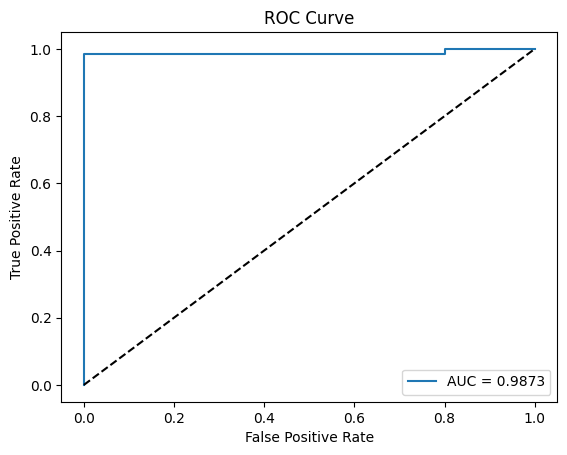

Deep SVDD Results:
AUC: 0.9873
Precision: 1.0000
Recall: 0.9683
F1: 0.9839
Accuracy: 0.9759
Threshold: 209.40069580078125


In [18]:
svdd_results = evaluate_anomaly_detection(svdd_scores, labels)
print("Deep SVDD Results:")
for k, v in svdd_results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

### SVM with Resnet results

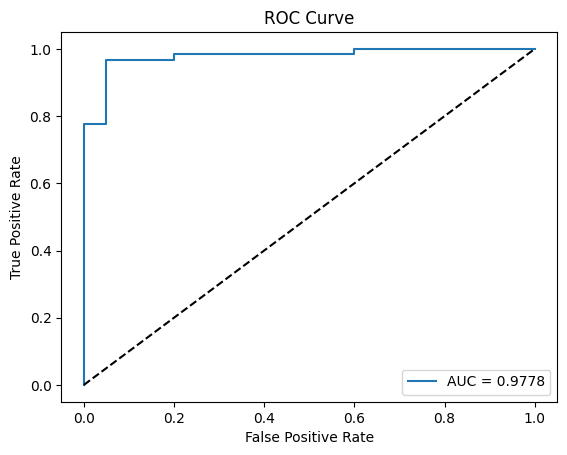

One-Class SVM ResNet Results:
AUC: 0.9778
Precision: 0.9836
Recall: 0.9524
F1: 0.9677
Accuracy: 0.9518
Threshold: 0.2725


In [19]:
svm_Resnet_results = evaluate_anomaly_detection(svm_ResNet_scores, labels)
print("One-Class SVM ResNet Results:")
for k, v in svm_Resnet_results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

### SVM with Vits results

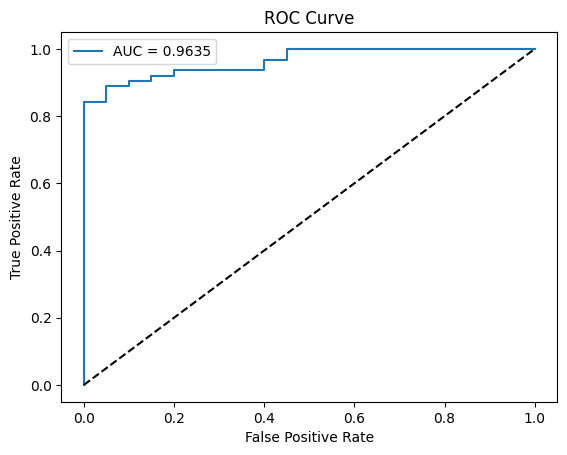

One-Class SVM Vits Results:
AUC: 0.9635
Precision: 1.0000
Recall: 0.8254
F1: 0.9043
Accuracy: 0.8675
Threshold: 0.1142


In [20]:
svm_vits_results = evaluate_anomaly_detection(svm_Vits_scores, labels)
print("One-Class SVM Vits Results:")
for k, v in svm_vits_results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

### Confusion Matrices 

In [29]:
predictions_to_df(svdd_results, svdd_scores)

,Good,Small,Large,Contamination
Normal Prediction,20,1,0,1
Anomaly Prediction,0,21,21,19


In [21]:
predictions_to_df(svm_Resnet_results, svm_ResNet_scores)

,Good,Small,Large,Contamination
Normal Prediction,19,1,0,2
Anomaly Prediction,1,21,21,18


In [22]:
predictions_to_df(svm_vits_results, svm_Vits_scores)

,Good,Small,Large,Contamination
Normal Prediction,20,7,0,4
Anomaly Prediction,0,15,21,16


### Comparision between svdd and svm

In [23]:
comparison = {
    'Metric': ['AUC', 'Precision', 'Recall', 'F1', 'Accuracy'],
    'Deep SVDD': [
        svdd_results['AUC'],
        svdd_results['Precision'],
        svdd_results['Recall'],
        svdd_results['F1'],
        svdd_results['Accuracy'],
    ],
    'One-Class SVM ResNet': [
        svm_Resnet_results['AUC'],
        svm_Resnet_results['Precision'],
        svm_Resnet_results['Recall'],
        svm_Resnet_results['F1'],
        svm_Resnet_results['Accuracy'],
    ],
    'One-Class SVM Vits': [
        svm_vits_results['AUC'],
        svm_vits_results['Precision'],
        svm_vits_results['Recall'],
        svm_vits_results['F1'],
        svm_vits_results['Accuracy'],
    ]
}


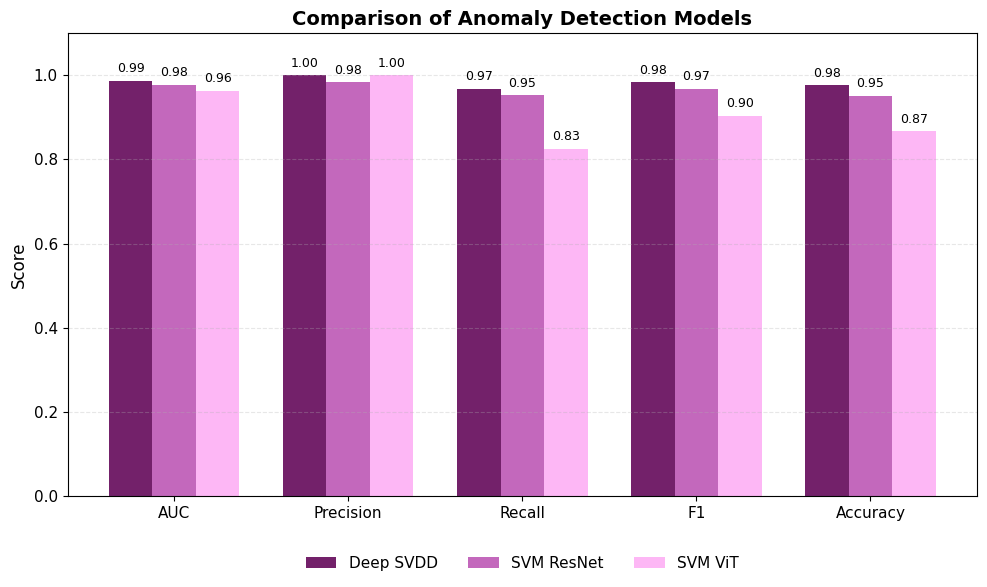

In [ ]:
# Create the DataFrame from the comparison dictionary
df = pd.DataFrame(comparison)
x = np.arange(len(df['Metric']))
width = 0.25

colors = ["#73216A", "#B33EA9C7", "#FD7DEE8C"]  

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, df['Deep SVDD'], width, label='Deep SVDD', color=colors[0])
rects2 = ax.bar(x, df['One-Class SVM ResNet'], width, label='SVM ResNet', color=colors[1])
rects3 = ax.bar(x + width, df['One-Class SVM Vits'], width, label='SVM ViT', color=colors[2])

# Customize axes and labels
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparison of Anomaly Detection Models', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['Metric'], fontsize=11)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)


# Add bar value labels
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
plt.rcParams.update({
    "font.size": 11,
    "font.family": "sans-serif",
    "axes.titleweight": "bold"
})

# Add soft grid
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
def compare_feature_spaces(features1, features2, labels, labels_map):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced1 = tsne.fit_transform(features1)
    reduced2 = tsne.fit_transform(features2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = ["#EC21E2", "#EBE0109D", "#20B92780", "#00B6F8"]  

    unique_labels = np.unique(labels)
    for idx, label in enumerate(unique_labels):
        mask = labels == label
        label_name = labels_map.get(label, str(label))
        color = colors[idx % len(colors)]
        axes[0].scatter(reduced1[mask, 0], reduced1[mask, 1], label=label_name, alpha=0.6, color=color)
        axes[1].scatter(reduced2[mask, 0], reduced2[mask, 1], label=label_name, alpha=0.6, color=color)

    axes[0].set_title(f"Pretrained ResNet18 Features (One-Class SVM)\nSilhouette Score: {silhouette_score(reduced1, [0 if label == 0 else 1 for label in labels]):.4f}")
    axes[1].set_title(f"SVDD-Trained Features (Deep SVDD)\nSilhouette Score: {silhouette_score(reduced2, [0 if label == 0 else 1 for label in labels]):.4f}")
    for ax in axes:
        ax.set_xlabel("t-SNE 1")
        ax.set_ylabel("t-SNE 2")
        ax.legend()
    plt.tight_layout()
    plt.show()

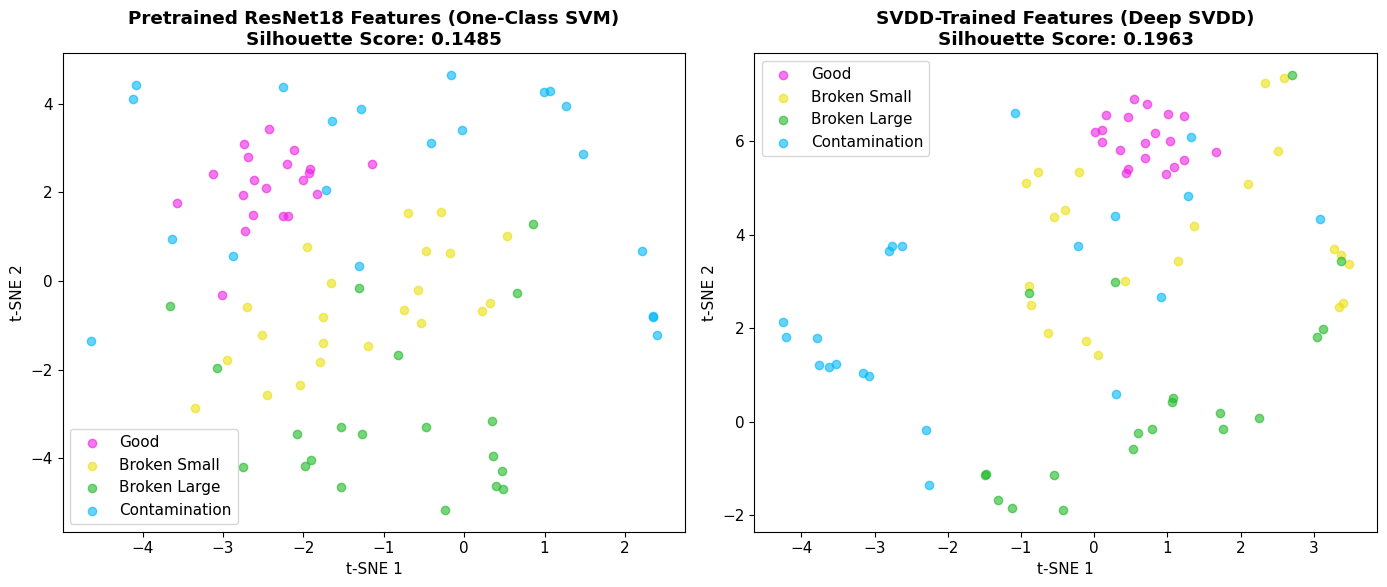

In [45]:
labels_map = {0: 'Good', 1: 'Broken Small', 2: 'Broken Large', 3: 'Contamination'}
svdd_features = extract_features(test_loader, svdd_model, device)
true_labels = [0]*20 + [1]*22 + [2]*20 + [3]*21  # 20 good, others are anomalies
compare_feature_spaces(svm_test_features_resnet, svdd_features, true_labels, labels_map)